In [1]:
import argparse
import logging
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from cryofib.n5_utils import read_volume, write_volume, get_attrs
from cryofib.preprocess_utils import percentile_norm
from cryofib.vis import plot_three_slices, get_random_cmap


from skimage.measure import label
from skimage.morphology import binary_opening
from skimage.segmentation import find_boundaries, watershed

import vigra

from elf.segmentation.utils import normalize_input

In [2]:
n5_path = "/scratch/buglakova/data/cryofib/segm_fibsem/F107/multicut_pipeline/F107_A1_em_pipeline.n5"

In [3]:
multicut = read_volume(n5_path, "multicut")
assert multicut is not None, "Key doesn't exist"

extra = read_volume(n5_path, "prediction/extra")
assert extra is not None, "Key doesn't exist"

<class 'str'>
Reading roi slice(None, None, None) of volume multicut from /scratch/buglakova/data/cryofib/segm_fibsem/F107/multicut_pipeline/F107_A1_em_pipeline.n5
Read volume with shape (1350, 1506, 1647), data type uint64
<class 'str'>
Reading roi slice(None, None, None) of volume prediction/extra from /scratch/buglakova/data/cryofib/segm_fibsem/F107/multicut_pipeline/F107_A1_em_pipeline.n5
Read volume with shape (1350, 1506, 1647), data type float32


In [77]:
boundaries = read_volume(n5_path, "prediction/boundaries", roi=roi)
assert extra is not None, "Key doesn't exist"

<class 'str'>
Reading roi (slice(300, 600, None), slice(None, None, None), slice(None, None, None)) of volume prediction/boundaries from /scratch/buglakova/data/cryofib/segm_fibsem/F107/multicut_pipeline/F107_A1_em_pipeline.n5
Read volume with shape (300, 1506, 1647), data type float32


In [5]:
roi = np.s_[300:600, :, :]

In [9]:
multicut.dtype

dtype('uint64')

In [25]:
input_map = extra[roi]
segmentation = multicut[roi].astype(np.uint32)

stat_feature_names = ["Count", "Kurtosis", "Maximum", "Minimum", "Quantiles", "Mean",
                        "RegionRadii", "Skewness", "Sum", "Variance"]
coord_feature_names = ["Weighted<RegionCenter>", "RegionCenter", 'Coord<Maximum >', 'Coord<Minimum >']
feature_names = stat_feature_names + coord_feature_names
node_features = vigra.analysis.extractRegionFeatures(input_map, segmentation,
                                                        features=feature_names)

In [29]:
node_features['Coord<Minimum >'].astype(np.uint16)

array([[   0,    0,    0],
       [   0,   75,   69],
       [   0,   90,   67],
       ...,
       [   0,    0,    0],
       [   0,    0,    0],
       [  24,  768, 1625]], dtype=uint16)

In [44]:
node_features.maxRegionLabel()

23748

In [87]:
def get_bbox_roi(img, coord_min, coord_max, margin=10):
    z_min = max(coord_min[0] - margin, 0)
    z_max = min(coord_max[0] + margin, img.shape[0])
    y_min = max(coord_min[1] - margin, 0)
    y_max = min(coord_max[1] + margin, img.shape[1])
    x_min = max(coord_min[2] - margin, 0)
    x_max = min(coord_max[2] + margin, img.shape[2])
    
    return np.s_[z_min:z_max, y_min:y_max, x_min:x_max]

In [47]:
coords_min = node_features['Coord<Minimum >'].astype(np.uint16)
coords_max = node_features['Coord<Maximum >'].astype(np.uint16)
extra_median = node_features["Quantiles"][:, 3]
areas = node_features["Count"]
indices = np.arange(0, node_features.maxRegionLabel() + 1)

In [48]:
replace_extra_indices = indices[extra_median > 0.5]

In [50]:
len(replace_extra_indices)

841

In [70]:
result = (segmentation.copy() + 2) * (segmentation > 0)

for idx in replace_extra_indices:
    if idx % 20 == 0: 
        print(idx)
    bbox_roi = get_bbox_roi(result, coords_min[idx, :], coords_max[idx, :])
    idx_result = result[bbox_roi]
    idx_result[idx_result == (idx + 2)] = 2
    result[bbox_roi] = idx_result
    areas[idx] = 0

220
4680
5000
5120
5760
6600
7460
7480
7540
7600
8060
8300
9160
9400
9560
9620
9660
9900
10360
10440
10680
11600
12260
15900
16560
17060
17080
17140
17300
17420
17860
18340
18440
18740
18840
18940
19220
19360
20340


In [79]:
replace_small_segments = indices[(areas > 0) & (areas < 1e5)]
len(replace_small_segments)

1224

In [82]:
areas[8464]

14.0

In [88]:
for idx in replace_small_segments:
    print(idx)
    bbox_roi = get_bbox_roi(result, coords_min[idx, :], coords_max[idx, :])
    idx_result = result[bbox_roi]
    idx_extra = input_map[bbox_roi]
    idx_boundaries = boundaries[bbox_roi]
    idx_result[idx_result == (idx + 2)] = 0
    ws_fill, _ = vigra.analysis.watershedsNew(normalize_input(np.maximum(idx_boundaries, idx_extra)), seeds=idx_result.astype(np.uint32))
    idx_result[idx_result == (idx + 2)] = ws_fill[idx_result == (idx + 2)]
    
    result[bbox_roi] = idx_result
    areas[idx] = 0

8464
8485
8502
8533
8566
8592
8593
8631
8640
8644
8650
8684
8704
8705
8764
8805
8806
8807
8808
8809
8810
8811
8920
8921
8965
9025
9040
9068
9088
9092
9104
9112
9237
9285
9300
9331
9375
9376
9382
9412
9422
9456
9468
9473
9493
9535
9574
9690
9700
9703
9714
9715
9760
9850
9858
9898
9905
9935
10010
10021
10026
10027
10040
10042
10045
10059
10061
10082
10083
10087
10103
10107
10108
10122
10126
10132
10149
10162
10172
10173
10174
10187
10188
10193
10200
10202
10208
10209
10222
10223
10225
10249
10250
10254
10256
10260
10268
10270
10292
10301
10305
10312
10318
10323
10324
10353
10355
10364
10365
10371
10382
10383
10386
10392
10398
10403
10416
10417
10421
10436
10455
10464
10465
10469
10470
10471
10482
10499
10518
10519
10520
10538
10545
10584
10599
10615
10623
10641
10644
10653
10669
10670
10688
10690
10691
10694
10698
10701
10702
10703
10737
10766
10773
10775
10793
10876
10885
10902
10906
10910
10920
10954
10955
10990
10994
11000
11002
11017
11029
11038
11042
11048
11049
11050
11051
11062
11

In [33]:
bbox_roi = get_bbox_roi(multicut[roi].astype(np.uint32), coords_min[3, :], coords_max[3, :])

In [35]:
bbox_roi

(slice(0, 154, None), slice(826, 1189, None), slice(67, 333, None))

In [37]:
label_3 = multicut[roi].astype(np.uint32)[bbox_roi] == 3

In [23]:
node_features["Quantiles"][:, 3]

array([9.58989709e-03, 2.49542248e-01, 8.05475491e-03, ...,
       0.00000000e+00, 0.00000000e+00, 8.78579924e-05])

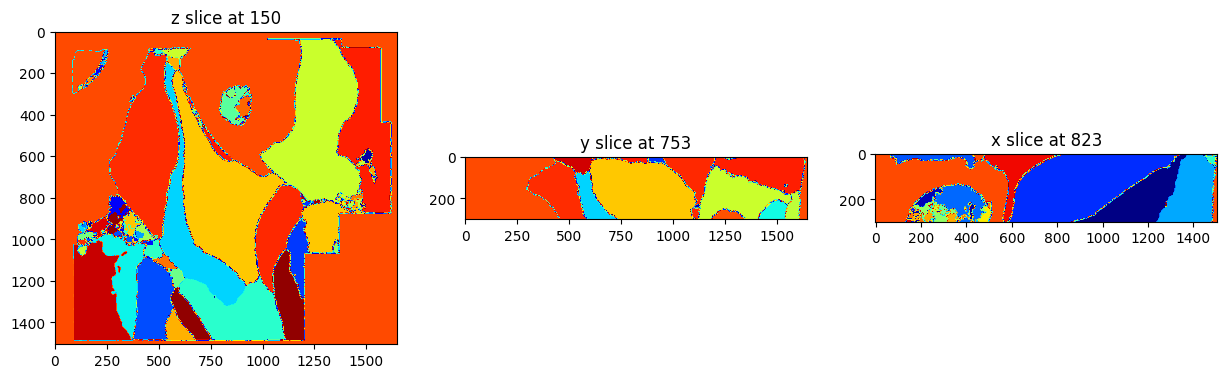

In [63]:
plot_three_slices(segmentation, save_path=None, cmap=get_random_cmap())

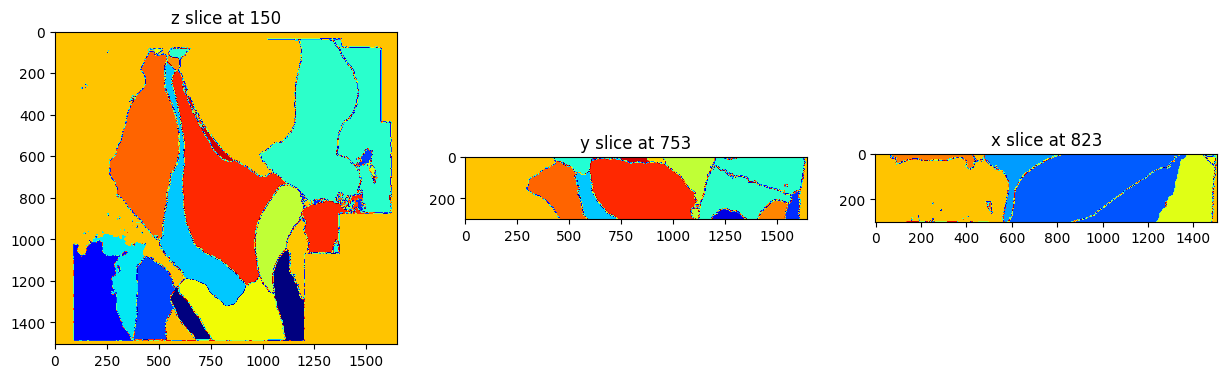

In [69]:
plot_three_slices(result, save_path=None, cmap=get_random_cmap())

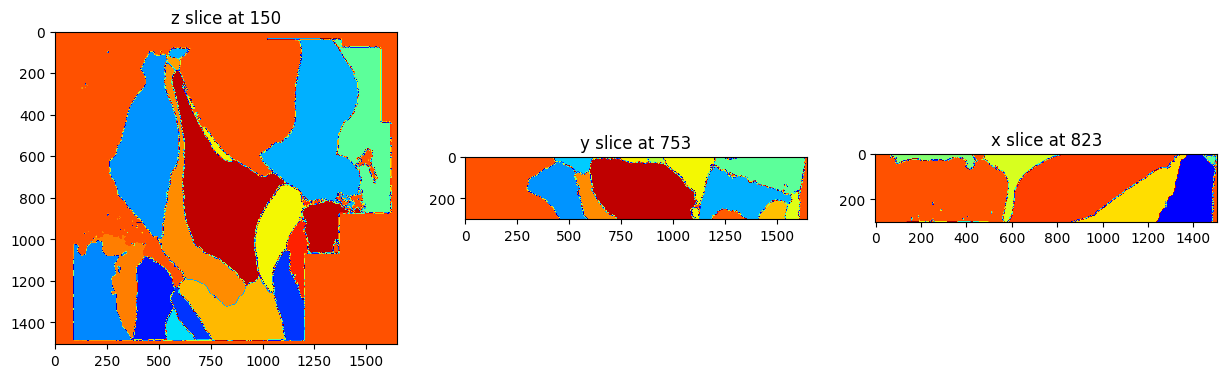

In [89]:
plot_three_slices(result, save_path=None, cmap=get_random_cmap())

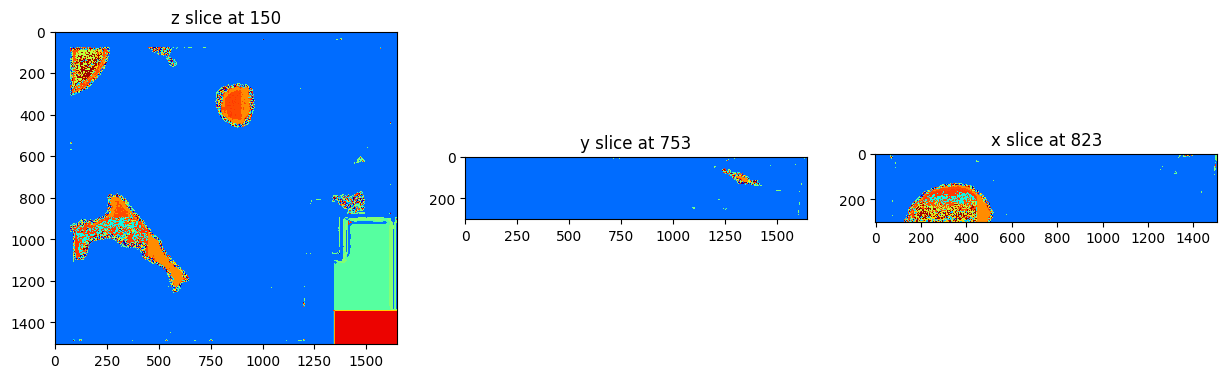

In [53]:
plot_three_slices(input_map, save_path=None, cmap=get_random_cmap())

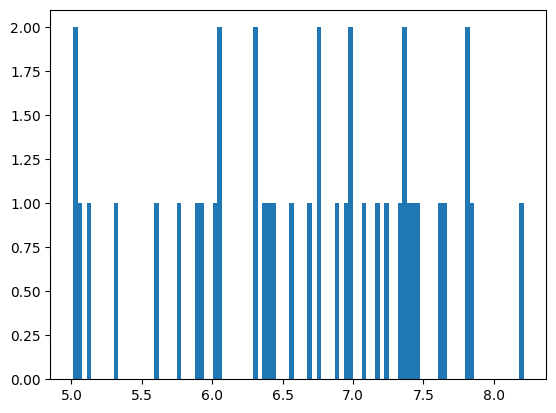

In [92]:
plt.hist(np.log10(areas[areas > 0]), bins=100);

In [108]:
x_pos = coords_min[:, 2][areas[:] > 0]
ind = np.argsort(x_pos)
renumbered = result.copy()
for new_idx, old_idx in enumerate(ind):
    if old_idx > 2:
        bbox_roi = get_bbox_roi(result, coords_min[old_idx, :], coords_max[old_idx, :])
        idx_result = renumbered[bbox_roi]
        idx_result[idx_result == old_idx] = new_idx + 3
        renumbered[bbox_roi] = idx_result

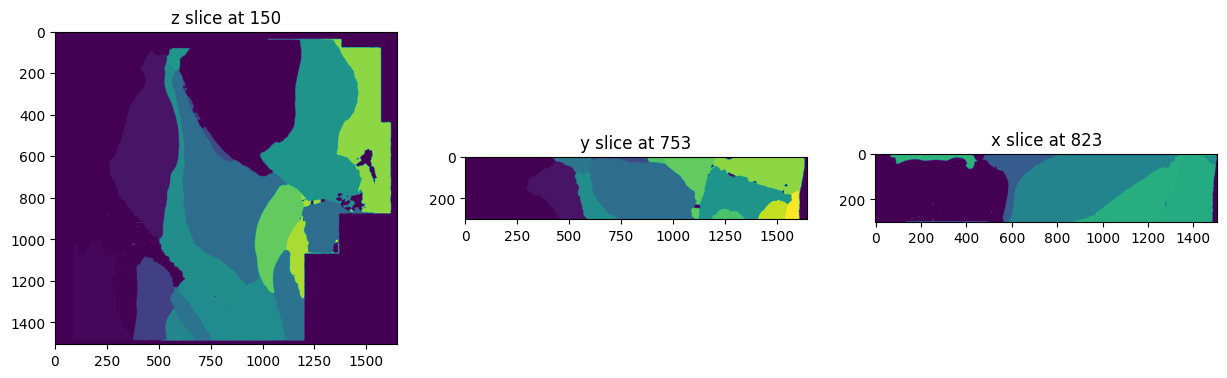

In [110]:
plot_three_slices(renumbered, save_path=None, cmap="viridis")

In [ ]:
plot_three_slices(result, save_path=None, cmap=get_random_cmap())

In [103]:
ind = np.argsort(x_pos)

In [102]:
x_pos[ind]

array([   0,    0,    0, ..., 1608, 1614, 1625], dtype=uint16)

(array([931., 192.,  60.,  22.,  30.,  32.,  19.,  15.,   8.,  20.,  12.,
         11.,  10.,   7.,   6.,   4.,   2.,   7.,  10.,   3.,   5.,   8.,
          3.,   6.,   4.,   4.,   7.,   3.,   4.,   6.,   5.,   8.,   4.,
          6.,   5.,   2.,   5.,   3.,   2.,   3.,   5.,   4.,   1.,   3.,
          1.,   4.,   1.,   1.,   1.,   1.,   0.,   1.,   1.,   2.,   1.,
          2.,   1.,   2.,   2.,   2.,   2.,   1.,   2.,   4.,   2.,   1.,
          2.,   3.,   2.,   1.,   4.,   1.,   3.,   1.,   3.,   3.,   2.,
          5.,   2.,   5.,   3.,   3.,   3.,   2.,   2.,   1.,   2.,   3.,
         10.,   7.,  10.,  10.,  10.,  10.,  10.,  23.,  32., 189., 235.,
        213.]),
 array([2.49595448e-07, 9.98156522e-03, 1.99628808e-02, 2.99441965e-02,
        3.99255121e-02, 4.99068277e-02, 5.98881433e-02, 6.98694589e-02,
        7.98507746e-02, 8.98320902e-02, 9.98134058e-02, 1.09794721e-01,
        1.19776037e-01, 1.29757353e-01, 1.39738668e-01, 1.49719984e-01,
        1.59701300e-01, 1.6968

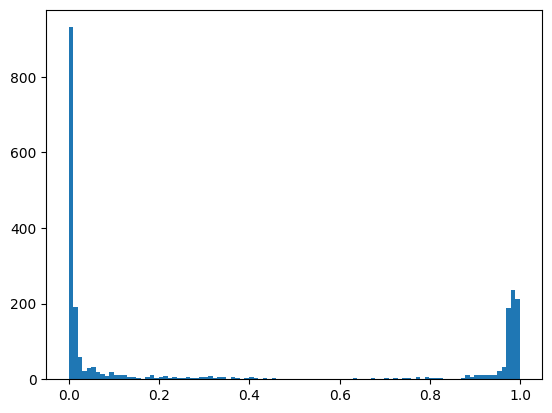

In [24]:
plt.hist(node_features["Quantiles"][:, 3][node_features["Count"] > 0], bins=100)

(array([ 46.,   0.,   0.,  25.,   0.,  17.,   0.,  17.,  10.,  14.,  17.,
          4.,  13.,  14.,  17.,  15.,  12.,  20.,  20.,  21.,  16.,  10.,
         18.,  17.,  78.,  87.,  85.,  87., 100.,  69.,  71.,  72.,  47.,
         70.,  62.,  50.,  69.,  72.,  78.,  74.,  67.,  70.,  67.,  54.,
         54.,  58.,  50.,  48.,  43.,  43.,  35.,  29.,  22.,  28.,  21.,
         14.,  13.,  12.,   7.,  14.,   8.,   9.,   8.,   6.,   8.,   2.,
          2.,   3.,   1.,   3.,   3.,   2.,   1.,   5.,   2.,   0.,   2.,
          4.,   1.,   2.,   0.,   1.,   2.,   1.,   2.,   1.,   1.,   1.,
          1.,   3.,   3.,   0.,   1.,   1.,   2.,   1.,   0.,   0.,   0.,
          1.]),
 array([0.        , 0.08214717, 0.16429433, 0.2464415 , 0.32858866,
        0.41073583, 0.49288299, 0.57503016, 0.65717732, 0.73932449,
        0.82147166, 0.90361882, 0.98576599, 1.06791315, 1.15006032,
        1.23220748, 1.31435465, 1.39650181, 1.47864898, 1.56079614,
        1.64294331, 1.72509048, 1.80723764, 1.

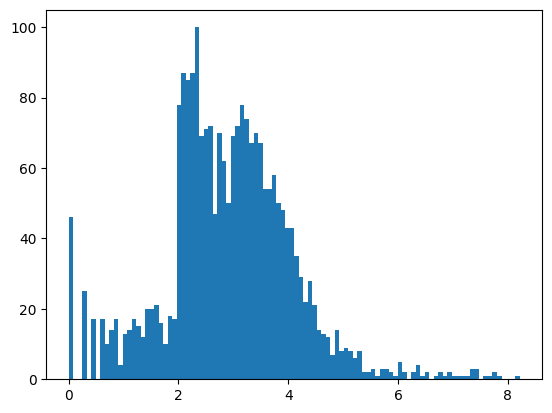

In [18]:
plt.hist(np.log10(node_features["Count"][node_features["Count"] > 0]), bins=100)

In [15]:
node_features.supportedFeatures()

['Central<PowerSum<2> >',
 'Central<PowerSum<3> >',
 'Central<PowerSum<4> >',
 'Coord<ArgMaxWeight >',
 'Coord<ArgMinWeight >',
 'Coord<DivideByCount<Principal<PowerSum<2> > > >',
 'Coord<Maximum >',
 'Coord<Minimum >',
 'Coord<PowerSum<1> >',
 'Coord<Principal<Kurtosis > >',
 'Coord<Principal<PowerSum<2> > >',
 'Coord<Principal<PowerSum<3> > >',
 'Coord<Principal<PowerSum<4> > >',
 'Coord<Principal<Skewness > >',
 'Count',
 'Global<Maximum >',
 'Global<Minimum >',
 'Histogram',
 'Kurtosis',
 'Maximum',
 'Mean',
 'Minimum',
 'Quantiles',
 'RegionAxes',
 'RegionCenter',
 'RegionRadii',
 'Skewness',
 'Sum',
 'Variance',
 'Weighted<Coord<DivideByCount<Principal<PowerSum<2> > > > >',
 'Weighted<Coord<PowerSum<1> > >',
 'Weighted<Coord<Principal<Kurtosis > > >',
 'Weighted<Coord<Principal<PowerSum<2> > > >',
 'Weighted<Coord<Principal<PowerSum<3> > > >',
 'Weighted<Coord<Principal<PowerSum<4> > > >',
 'Weighted<Coord<Principal<Skewness > > >',
 'Weighted<PowerSum<0> >',
 'Weighted<RegionAxe